# Matrix multiplication from scratch
Building a deep learning library starting from scratch.

## Check imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_00 import *
import operator

def test(a, b, cmp, cname=None):
    if cname is None: cname=cmp.__name__
    assert cmp(a,b),f"{cname}:\n{a}\n{b}"
        
def test_eq(a,b):
    test(a,b,operator.eq,'==')

In [3]:
test_eq(TEST,'test')

## Get MNIST data

In [4]:
#export
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor

MNIT_URL = 'http://deeplearning.net/data/mnist/mnist.pkl'

In [5]:
path = datasets.download_data(MNIT_URL, ext='.gz')

In [6]:
path

PosixPath('/home/fabiograetz/.fastai/data/mnist.pkl.gz')

In [7]:
with gzip.open(path, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

**Convert numpy arrays to PyTorch tensors:**

In [8]:
x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))

In [9]:
type(x_train)

torch.Tensor

In [10]:
n,c = x_train.shape

In [11]:
assert n==y_train.shape[0]==50000
test_eq(c,28*28)
test_eq(y_train.min(), 0)
test_eq(y_train.max(), 9)

In [12]:
mpl.rcParams['image.cmap'] = 'gray'

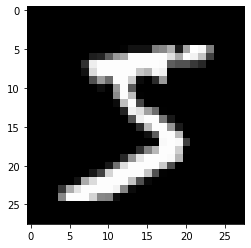

In [13]:
plt.imshow(x_train[0].view((28,28)))

## Initial python model

In [14]:
weights = torch.randn(784,10)
bias = torch.zeros(10)

### Matrix multiplication

In [15]:
def matmul(a,b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac==br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac):
                c[i,j] += a[i,k] * b[k,j]
    return c

In [16]:
m1 = x_valid[:5]
m2 = weights
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [17]:
%time t1 = matmul(m1,m2)

CPU times: user 830 ms, sys: 1.25 ms, total: 831 ms
Wall time: 834 ms


In [18]:
t1.shape

torch.Size([5, 10])

Ok, this is insanely slow. We need to speed this up :)

To do this we use *elementwise operations* such as +, -, *, /, >, <, ==.

Example:

Frobenius norm:

$||A||_F=\left(\sum_{i,j=1}^{n,m} a_{i,j}^2\right)^{1/2}$

In [19]:
m = tensor([[1., 2., 3.], [4., 5., 6.], [7., 8., 9.]])

In [20]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [21]:
(m*m).sum().sqrt()  # The multiplication here is elementwise!
                    # equivalent to m.pow(2)

tensor(16.8819)

### Matrix multiplication using elementwise operations

In [22]:
def matmul(a,b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac==br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            # Trailing ",:""  are actually not necessary
            c[i,j] += (a[i,:] * b[:,j]).sum()  # row i of a and col j of b are multiplied elementwise
    return c

In [23]:
m1[1,:].shape

torch.Size([784])

In [24]:
m2[:,1].shape

torch.Size([784])

In [25]:
%timeit -n 10 _=matmul(m1,m2)

1.83 ms ± 164 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [26]:
782 / 1.69

462.72189349112426

In [27]:
#export
def near(a,b):
    return torch.allclose(a, b, rtol=1e-3, atol=1e-5)
def test_near(a,b):
    test(a, b, near)

You cannot check for equality when dealing with floating point numbers

In [28]:
test_near(t1, matmul(m1, m2))

### Matrix multiplication using *broadcasting*
The term broadcasting describes how numpy treats arrays with 
different shapes during arithmetic operations. Subject to certain 
constraints, the smaller array is “broadcast” across the larger 
array so that they have compatible shapes. Broadcasting provides a 
means of vectorizing array operations so that looping occurs in C
instead of Python. It does this without making needless copies of 
data and usually leads to efficient algorithm implementations.

#### Examples

In [33]:
a = tensor([10., 5., -1.])

In [34]:
a

tensor([10.,  5., -1.])

**Broadcast with scalar**

In [36]:
a > 0

tensor([1, 1, 0], dtype=torch.uint8)

In [37]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [38]:
3 * m

tensor([[ 3.,  6.,  9.],
        [12., 15., 18.],
        [21., 24., 27.]])

**Broadcast a vector to a matrix:**

In [39]:
a

tensor([10.,  5., -1.])

In [40]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [41]:
a.shape, m.shape

(torch.Size([3]), torch.Size([3, 3]))

In [42]:
a + m

tensor([[11.,  7.,  2.],
        [14., 10.,  5.],
        [17., 13.,  8.]])

In [43]:
m + a

tensor([[11.,  7.,  2.],
        [14., 10.,  5.],
        [17., 13.,  8.]])

**The rows are not really copied despite the looks. The rows are given a *stride* of 0.**

In [44]:
t = a.expand_as(m)

In [45]:
t

tensor([[10.,  5., -1.],
        [10.,  5., -1.],
        [10.,  5., -1.]])

In [46]:
m + t

tensor([[11.,  7.,  2.],
        [14., 10.,  5.],
        [17., 13.,  8.]])

In [47]:
t.storage()

 10.0
 5.0
 -1.0
[torch.FloatStorage of size 3]

In [48]:
t.stride(), t.shape

((0, 1), torch.Size([3, 3]))

**Convert a 1-dim array into a 2-dim array (one of the dimensions having a value of 1) by using `unsqueeze()` or indexing with the special value `[None]`.**

In [49]:
a.unsqueeze(0)

tensor([[10.,  5., -1.]])

In [50]:
a.unsqueeze(1)

tensor([[10.],
        [ 5.],
        [-1.]])

In [64]:
a[...,None]

tensor([[10.],
        [ 5.],
        [-1.]])

In [53]:
a.shape, a.unsqueeze(0).shape, a.unsqueeze(1).shape

(torch.Size([3]), torch.Size([1, 3]), torch.Size([3, 1]))

In [56]:
a.shape, a[None,:].shape, a[:,None].shape

(torch.Size([3]), torch.Size([1, 3]), torch.Size([3, 1]))

**Trailing `:,` can be skipped and `...` means *all preceeding dimensions*.**

In [57]:
a[None].shape, a[...,None].shape

(torch.Size([1, 3]), torch.Size([3, 1]))

In [61]:
a[:,None].expand_as(m)

tensor([[10., 10., 10.],
        [ 5.,  5.,  5.],
        [-1., -1., -1.]])

In [51]:
m 

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

**The following two lines are equivalent:**

In [62]:
m + a[:,None]

tensor([[11., 12., 13.],
        [ 9., 10., 11.],
        [ 6.,  7.,  8.]])

In [52]:
m + a.unsqueeze(1)

tensor([[11., 12., 13.],
        [ 9., 10., 11.],
        [ 6.,  7.,  8.]])

#### Let's implement matrix multiplication using broadcasting

In [118]:
def matmul(a,b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac==br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        c[i] = (a[i].unsqueeze(-1) * b).sum(dim=0)
    return c

In [119]:
test_near(t1, matmul(m1, m2))

In [120]:
%timeit -n 10 _=matmul(m1, m2)

247 µs ± 13.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [121]:
834000 / 247

3376.518218623482

**Explanation:**

In [113]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [111]:
m[0]  # 0th row

tensor([1., 2., 3.])

In [112]:
m[0].unsqueeze(-1)

tensor([[1.],
        [2.],
        [3.]])

In [114]:
m[0].unsqueeze(-1) * m

tensor([[ 1.,  2.,  3.],
        [ 8., 10., 12.],
        [21., 24., 27.]])

In [117]:
(m[0].unsqueeze(-1) * m).sum(0)  # sum along the rows

tensor([30., 36., 42.])

#### Broadcasting rules

In [122]:
a

tensor([10.,  5., -1.])

In [124]:
a[None,:], a[None,:].shape

(tensor([[10.,  5., -1.]]), torch.Size([1, 3]))

In [125]:
a[:,None], a[:,None].shape

(tensor([[10.],
         [ 5.],
         [-1.]]), torch.Size([3, 1]))

In [126]:
a[None,:] * a[:,None]

tensor([[100.,  50., -10.],
        [ 50.,  25.,  -5.],
        [-10.,  -5.,   1.]])

In [127]:
a[None] > a[:,None]

tensor([[0, 0, 0],
        [1, 0, 0],
        [1, 1, 0]], dtype=torch.uint8)

When operating on two arrays/tensors, Numpy/PyTorch compares their shapes element-wise. It starts with the **trailing dimensions**, and works its way forward. Two dimensions are **compatible** when

* they are equal, or
* one of them is 1, in which case that dimension is broadcasted to make it the same size

Arrays do not need to have the same number of dimensions. For example, if you have a 256*256*3 array of RGB values, and you want to scale each color in the image by a different value, you can multiply the image by a one-dimensional array with 3 values. Lining up the sizes of the trailing axes of these arrays according to the broadcast rules, shows that they are compatible:
```
 Image  (3d array): 256 x 256 x 3
 Scale  (1d array):             3
 Result (3d array): 256 x 256 x 3
```
The [numpy documentation](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html#general-broadcasting-rules) includes several examples of what dimensions can and can not be broadcast together.

### Matrix multiplication with *Einstein summation*
A notation that combines products and a sum in a compact way

**If a label appears only once, it is not summed. The following, thus, produces a view of `m` with no changes:**

In [136]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [135]:
torch.einsum('ij',m)

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

**When a label is repeated, you do a dot product over this dimension.**

In [137]:
def matmul(a,b): return torch.einsum('ik,kj->ij', a, b)

In [138]:
test_near(t1, matmul(m1, m2))

In [139]:
%timeit -n 10 _=matmul(m1, m2)

57.2 µs ± 6.73 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [140]:
834000 / 57

14631.578947368422

### Finally: compare this to PyTorch's matmul (uses cuBLAS)

In [150]:
%timeit -n 10 t2 = m1.matmul(m2)

9.6 µs ± 3.55 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [151]:
834000 / 9.6

86875.0

In [152]:
t2 = m1@m2

In [153]:
test_near(t1, t2)

### Export

In [154]:
!python notebook2script.py 01_matmul.ipynb

Converted 01_matmul.ipynb to exp/nb_01.py
